In [64]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
env = gym.envs.make("Breakout-v0")

In [12]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [13]:
plt.ion()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

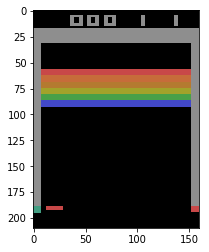

In [30]:
for i in range(100):
    next_state, reward, is_terminal, _ = env.step(np.random.choice([0,1,2,3]))
    plt.imshow(next_state)
    plt.plot()

In [36]:
Y = 0.2116 * next_state[:,:,0] + 0.7152 * next_state[:,:,1] + 0.0722 * next_state[:,:,2]

In [51]:
from torchvision.transforms import Grayscale, Resize

In [54]:
gray = Grayscale(1)
size = Resize([84, 84], interpolation=Image.CUBIC)

In [45]:
im = Image.fromarray(next_state)

In [58]:
tensor = torch.from_numpy(next_state)

In [62]:
tensor.unsqueeze(0).shape

torch.Size([1, 210, 160, 3])

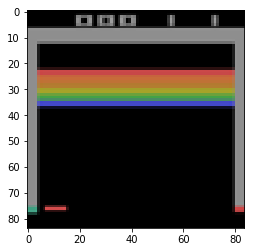

In [55]:
plt.imshow(size(im))

In [112]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(8, 8), stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 4), stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        conv_out_dim = self._get_conv2d_out_dim(self._get_conv2d_out_dim(self._get_conv2d_out_dim(h, 8, 4), 4, 2), 3, 1)
        print(conv_out_dim)
        self.fc1 = nn.Linear(in_features=conv_out_dim*conv_out_dim*64, out_features=512)
        self.bn4 = nn.BatchNorm1d(1)
        self.output = nn.Linear(in_features=512, out_features=4)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.fc1((x.view(x.size(0), -1)))))
        return self.output(x)

    def _get_conv2d_out_dim(self, input_dim, kernel_size, stride, pad=0):
        out_dim = np.floor((input_dim - kernel_size + 2 * pad) / stride + 1)
        return int(out_dim)

In [113]:
tt = DQN(84, 84)

7


In [86]:
pipeline = T.Compose([T.ToPILImage(),
                    T.Resize([84, 84]),
                    T.ToTensor()])

In [99]:
def state_processor(np_array):
    Y = 0.2116 * np_array[:, :, 0] + 0.7152 * np_array[:, :, 1] + 0.0722 * np_array[:, :, 2]
    return pipeline(torch.from_numpy(np.expand_dims(Y.astype(np.float32), 0))).unsqueeze(0).to("cpu")

In [110]:
x = state_processor(next_state)

In [114]:
tt.forward(x)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [71]:
env.action_space.n

4